### hte purpose of this notebook is to construct a variable days_since
 - for each order, the days_since should be the number of days since the first order made by the same merchant

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
def add_date_cols(baskets):
    baskets['datetime'] = pd.to_datetime(baskets['placed_at'])
    baskets['year'] = baskets["datetime"].dt.year
    baskets['month'] = baskets["datetime"].dt.month
    baskets['date'] = baskets["datetime"].dt.date
    baskets['day'] = baskets["datetime"].dt.day
    baskets['hour'] = baskets["datetime"].dt.hour
    baskets['weekday'] = baskets["datetime"].dt.weekday
    baskets['year_month'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%m"))
    baskets['month_num'] = (baskets['year'] - 2021) * 12 + baskets['month']
    baskets['year_week'] = baskets["datetime"].apply(lambda t: t.strftime("%Y-%W")) # this makes the beginning of Jan 2022 as week 2022-00 , not 2022-52
    baskets['week_num'] = baskets["datetime"].apply(lambda t: int(t.strftime("%W"))) 
    baskets['iso_week_num'] = baskets["datetime"].dt.isocalendar().week # this returns week number 52 for Jan 1, 2021, not 0 which is what we want
    baskets['cum_week_num'] = (baskets['year'] - 2021) * 52 + baskets['week_num']
    return baskets
def get_merchant_attributes(baskets):
    merchant_attributes = baskets.groupby(['merchant_id']).agg(
        total_spent = ('spent', 'sum'), 
        num_orders = ('order_id', 'nunique'), 
        first_month = ('month_num', 'min'), 
        last_month = ('month_num', 'max'), 
        num_months = ('month_num', 'nunique'), 
        num_weeks = ('week_num', 'nunique'), 
        num_days = ('date', 'nunique'), 
        num_skus = ('sku_id','nunique'), 
        num_top_cats = ('top_cat','nunique'), 
        num_sub_cats = ('sub_cat','nunique'),
    ).reset_index()
    merchant_attributes['avg_spent_per_order'] = merchant_attributes.total_spent / merchant_attributes.num_orders
    merchant_attributes['tenure_month'] = merchant_attributes.last_month - merchant_attributes.first_month +1
    return merchant_attributes

In [3]:
filename = './AwanTunai_transaction_data.csv'
baskets = pd.read_csv(filename)
baskets["spent"] = baskets["qty"] * baskets["price"] # column wide multiplication
baskets = add_date_cols(baskets)

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html

In [4]:
merchant_day_orders = baskets.groupby(['merchant_id', 'date']).agg(
    order_spent = ('spent','sum')
).reset_index()
merchant_day_orders['date_diff'] = merchant_day_orders.groupby(['merchant_id'])["date"].diff().apply(pd.Timedelta)
merchant_day_orders['days_gap'] = merchant_day_orders.date_diff.where(merchant_day_orders.date_diff.notnull(), timedelta(days=0, seconds=0, microseconds=0)).dt.days

min_date = merchant_day_orders.groupby("merchant_id").agg(
    min_date = ("date", "min")
    ).reset_index()

merchant_day_orders["min_date"] = merchant_day_orders.merge(min_date, left_on="merchant_id", right_on = "merchant_id")["min_date"]
merchant_day_orders["days_since"] = (merchant_day_orders["date"] - merchant_day_orders["min_date"]).dt.days
merchant_day_orders

,merchant_id,date,order_spent,date_diff,days_gap,min_date,days_since
0,1,2022-01-27,89000.0,NaT,0,2022-01-27,0
1,1,2022-04-08,1857000.0,71 days,71,2022-01-27,71
2,1,2022-04-09,205000.0,1 days,1,2022-01-27,72
3,1,2022-04-21,1326200.0,12 days,12,2022-01-27,84
4,1,2022-04-23,1888200.0,2 days,2,2022-01-27,86
...,...,...,...,...,...,...,...
25370,356,2022-12-21,2107000.0,6 days,6,2022-11-29,22
25371,356,2022-12-22,1626000.0,1 days,1,2022-11-29,23
25372,356,2022-12-28,1875000.0,6 days,6,2022-11-29,29
25373,357,2022-12-13,260000.0,NaT,0,2022-12-13,0


### the above accomplished two things:
 - day gaps between consecutive orders for each merchant
 - days elapsed for an order since the first order made by the same merchant

### two things to pay attention:
 - diff method from pandas
 - timedelta class from pandas

In [5]:
df = merchant_day_orders  ## your df
mlist = baskets['merchant_id'].unique()
merchants = pd.DataFrame(data = np.zeros(mlist.shape[0]), columns=["beta"], index = mlist)

for merchant_id, beta in merchants.iterrows():
   temp = df[df['merchant_id'] == merchant_id]
   model = smf.ols(formula = 'order_spent~days_since', data = temp).fit()
   merchants.loc[merchant_id,"beta"] = model.params['days_since']
merchants

,beta
9,-641.602030
10,5.543343
11,-155955.200952
12,-509.328358
13,-5711.356923
...,...
353,1325.983718
354,-1088.811112
356,-71540.448343
357,133933.333333


<AxesSubplot:>

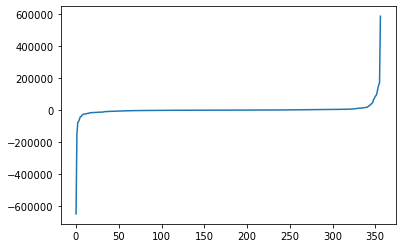

In [6]:
merchants.beta.sort_values().reset_index(drop=True).plot()